In [1]:
from typing import Tuple

import matplotlib
import meep as mp
import nlopt
import numpy as np

matplotlib.use("agg")
import matplotlib.pyplot as plt


def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n = p[3 * n + 0]
        x_n = p[3 * n + 1]
        g_n = p[3 * n + 2]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray, grad: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x as
    well as the gradient of this error with respect to each Lorentzian
    polarizability parameter in p and saving the result in grad.
    """
    N = len(p) // 3
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    for n in range(N):
        A_n = p[3 * n + 0]
        x_n = p[3 * n + 1]
        g_n = p[3 * n + 2]
        d = 1 / (np.square(x_n) - np.square(x) - 1j * x * g_n)
        if grad.size > 0:
            grad[3 * n + 0] = 2 * np.real(np.dot(np.conj(yp - y), d))
            grad[3 * n + 1] = (
                -4 * x_n * A_n * np.real(np.dot(np.conj(yp - y), np.square(d)))
            )
            grad[3 * n + 2] = (
                -2 * A_n * np.imag(np.dot(np.conj(yp - y), x * np.square(d)))
            )
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    alg=nlopt.LD_LBFGS,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the NLopt algorithm alg for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    opt = nlopt.opt(alg, len(p0))
    opt.set_ftol_rel(tol)
    opt.set_maxeval(maxeval)
    opt.set_lower_bounds(np.zeros(len(p0)))
    opt.set_upper_bounds(float("inf") * np.ones(len(p0)))
    opt.set_min_objective(lambda p, grad: lorentzerr(p, x, y, grad))
    local_opt = nlopt.opt(nlopt.LD_LBFGS, len(p0))
    local_opt.set_ftol_rel(1e-10)
    local_opt.set_xtol_rel(1e-8)
    opt.set_local_optimizer(local_opt)
    popt = opt.optimize(p0)
    minf = opt.last_optimum_value()
    return popt, minf


if __name__ == "__main__":
    # Import the complex refractive index profile from a CSV file.
    # The file format is three comma-separated columns:
    #     wavelength (nm), real(n), imag(n).
    mydata = np.genfromtxt("Phys. Rev. B 27, 985-1009 (1983) Si n and k values.csv", delimiter=",")
    n = mydata[:, 1] + 1j * mydata[:, 2]

    # Fitting parameter: the instantaneous (infinite frequency) dielectric.
    # Should be > 1.0 for stability and chosen such that
    # np.amin(np.real(eps)) is ~1.0. eps is defined below.
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    # Fit only the data in the wavelength range of [wl_min, wl_max].
    wl = mydata[:, 0]
    wl_min = 399  # minimum wavelength (units of nm)
    wl_max = 701  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    # Note: an equally spaced grid of wavelengths results in the larger
    #       wavelengths having a finer frequency grid than smaller ones.
    #       This feature may impact the accuracy of the fit.
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, 1e-25, 50000
        )
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.where(np.min(mins) == mins)[0][0]
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq = ps[idx_opt][3 * n + 1]
        mymaterial_gamma = ps[idx_opt][3 * n + 2]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    mymaterial = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)

    # Plot the fit and the actual data for comparison.
    mymaterial_eps = [mymaterial.epsilon(f)[0][0] for f in freqs_reduced]

    fig, ax = plt.subplots(ncols=2)

    ax[0].plot(wl_reduced, np.real(eps_reduced) + eps_inf, "bo-", label="actual")
    ax[0].plot(wl_reduced, np.real(mymaterial_eps), "ro-", label="fit")
    ax[0].set_xlabel("wavelength (nm)")
    ax[0].set_ylabel(r"real($\epsilon$)")
    ax[0].legend()

    ax[1].plot(wl_reduced, np.imag(eps_reduced), "bo-", label="actual")
    ax[1].plot(wl_reduced, np.imag(mymaterial_eps), "ro-", label="fit")
    ax[1].set_xlabel("wavelength (nm)")
    ax[1].set_ylabel(r"imag($\epsilon$)")
    ax[1].legend()

    fig.suptitle(
        f"Comparison of Actual Material Data and Fit\n"
        f"using Drude-Lorentzian Susceptibility"
    )

    fig.subplots_adjust(wspace=0.3)
    fig.savefig("eps_fit_sample.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

iteration:,   0, ps_str, 0.121042
iteration:,   1, ps_str, 0.131993
iteration:,   2, ps_str, 2.629931
iteration:,   3, ps_str, 0.135838
iteration:,   4, ps_str, 0.508701
iteration:,   5, ps_str, 0.121149
iteration:,   6, ps_str, 0.394583
iteration:,   7, ps_str, 0.239510
iteration:,   8, ps_str, 0.252707
iteration:,   9, ps_str, 0.155743
iteration:,  10, ps_str, 0.320520
iteration:,  11, ps_str, 0.132932
iteration:,  12, ps_str, 0.133645
iteration:,  13, ps_str, 0.145066
iteration:,  14, ps_str, 0.167134
iteration:,  15, ps_str, 0.304807
iteration:,  16, ps_str, 0.136511
iteration:,  17, ps_str, 0.530034
iteration:,  18, ps_str, 0.177473
iteration:,  19, ps_str, 0.216604
iteration:,  20, ps_str, 0.297272
iteration:,  21, ps_str, 0.128748
iteration:,  22, ps_str, 0.120526
iteration:,  23, ps_str, 0.209153
iteration:,  24, ps_str, 0.185967
iteration:,  25, ps_str, 0.120751
iteration:,  26, ps_str, 0.133134
iteration:,  27, ps_str, 0.457342
iteration:,  28, ps_str, 0.352355
iteration:,  2

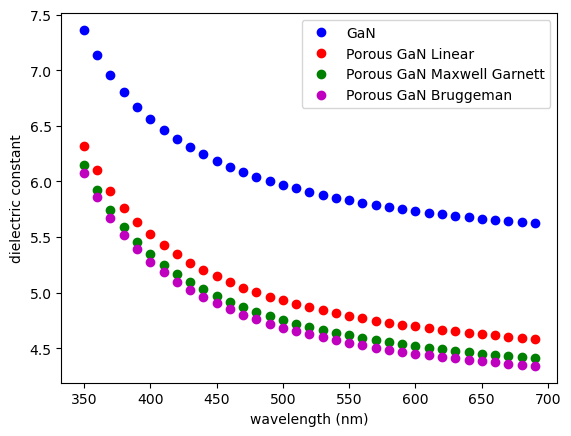

In [2]:
from meep.materials import GaN,AlN
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
porosity = 0.4

# gallium nitride (GaN), alpha phase (wurtzite), from A.S. Barker Jr. and M. Ilegems, Physical Review B, Vol. 7, pp. 743-50 (1973)
# ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-o
# ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-e
# wavelength range: 0.35 - 10 μm

## NOTE: ordinary (o) axes in X and Y, extraordinary (e) axis in Z
um_scale = 1.0

# conversion factor for eV to 1/μm [=1/hc]
eV_um_scale = um_scale / 1.23984193

GaN_range = mp.FreqRange(min=um_scale / 10.0, max=um_scale / 0.35)

GaN_frq1 = 1 / (0.256 * um_scale)
GaN_gam1 = 0
GaN_sig1 = 1.75
GaN_frq2 = 1 / (17.86 * um_scale)
GaN_gam2 = 0
GaN_sig2 = 4.1

GaN_susc_o = [
    mp.LorentzianSusceptibility(
        frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_sig1 * mp.Vector3(1, 1, 0)
    ),
    mp.LorentzianSusceptibility(
        frequency=GaN_frq2, gamma=GaN_gam2, sigma_diag=GaN_sig2 * mp.Vector3(1, 1, 0)
    ),
]

GaN_frq1 = 1 / (18.76 * um_scale)
GaN_gam1 = 0
GaN_sig1 = 5.08

GaN_susc_e = [
    mp.LorentzianSusceptibility(
        frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_sig1 * mp.Vector3(0, 0, 1)
    )
]

GaN = mp.Medium(
    epsilon_diag=mp.Vector3(3.6, 3.6, 5.35),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)

porous_gan_linear=mp.Medium(
    epsilon_diag=porosity*mp.Vector3(1,1,1) + (1-porosity)*GaN.epsilon_diag,
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,

)
eps_x = GaN.epsilon_diag.x * (1 - (3*porosity*(GaN.epsilon_diag.x - 1))/(2*GaN.epsilon_diag.x + 1 + porosity*(GaN.epsilon_diag.x - 1)))

eps_y = GaN.epsilon_diag.y * (1 - (3*porosity*(GaN.epsilon_diag.y - 1))/(2*GaN.epsilon_diag.y + 1 + porosity*(GaN.epsilon_diag.y - 1)))

eps_z = GaN.epsilon_diag.z * (1 - (3*porosity*(GaN.epsilon_diag.z - 1))/(2*GaN.epsilon_diag.z + 1 + porosity*(GaN.epsilon_diag.z - 1)))

porous_gan_max_garnett=mp.Medium(
    
    
    epsilon_diag = mp.Vector3(eps_x, eps_y, eps_z),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)
x_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.x)
b_eps_x = (x_c+(x_c**2+8*GaN.epsilon_diag.x)**0.5)/4
y_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.y)
b_eps_y = (y_c+(y_c**2+8*GaN.epsilon_diag.y)**0.5)/4
z_c=(3*porosity-1)*1+(3*(1-porosity)-1)*(GaN.epsilon_diag.z)
b_eps_z = (z_c+(z_c**2+8*GaN.epsilon_diag.z)**0.5)/4

porous_gan_bruggeman=mp.Medium(
    epsilon_diag=mp.Vector3(b_eps_x, b_eps_y, b_eps_z),
    E_susceptibilities=GaN_susc_o + GaN_susc_e,
    valid_freq_range=GaN_range,
)



for i in np.arange(350,700,10):
    plt.plot(i, GaN.epsilon(1/(i/1000))[0][0], 'bo')
    plt.plot(i, porous_gan_linear.epsilon(1/(i/1000))[0][0], 'ro')
    plt.plot(i, porous_gan_max_garnett.epsilon(1/(i/1000))[0][0], 'go')
    plt.plot(i, porous_gan_bruggeman.epsilon(1/(i/1000))[0][0], 'mo')
    plt.xlabel("wavelength (nm)")
    plt.ylabel("dielectric constant")
    plt.legend(['GaN','Porous GaN Linear','Porous GaN Maxwell Garnett','Porous GaN Bruggeman'])
plt.show()


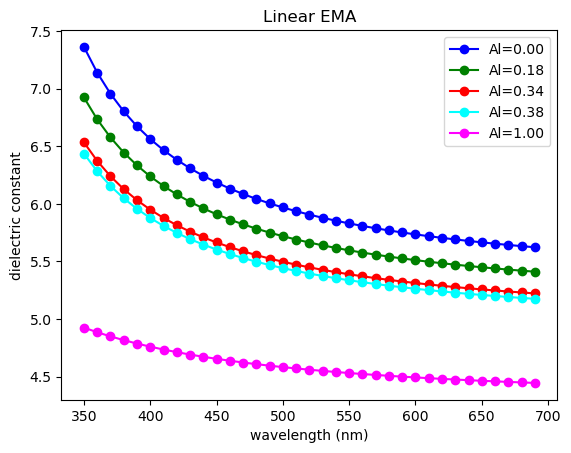

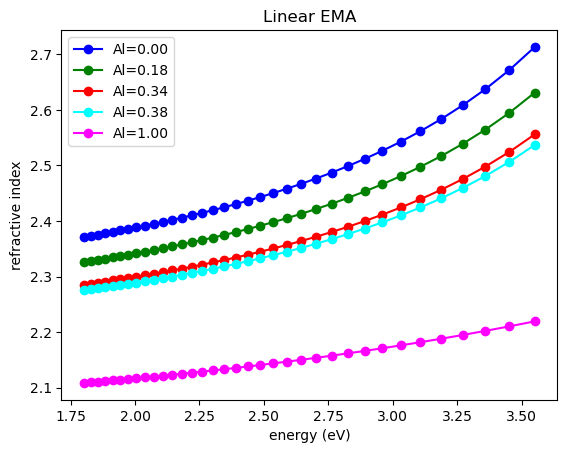

In [3]:
def AlGaN_linear(Al_comp):   
    GaN_comp = 1 - Al_comp

    # gallium nitride (GaN), alpha phase (wurtzite), from A.S. Barker Jr. and M. Ilegems, Physical Review B, Vol. 7, pp. 743-50 (1973)
    # ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-o
    # ref: https://refractiveindex.info/?shelf=main&book=GaN&page=Barker-e
    # wavelength range: 0.35 - 10 μm

    ## NOTE: ordinary (o) axes in X and Y, extraordinary (e) axis in Z
    um_scale = 1.0

    # conversion factor for eV to 1/μm [=1/hc]
    eV_um_scale = um_scale / 1.23984193

    GaN_range = mp.FreqRange(min=um_scale / 10.0, max=um_scale / 0.35)
    GaN_frq1 = 1 / (0.256 * um_scale)
    GaN_gam1 = 0
    GaN_sig1 = 1.75
    GaN_frq2 = 1 / (17.86 * um_scale)
    GaN_gam2 = 0
    GaN_sig2 = 4.1

    AlGaN_GaN_susc_o = [
        mp.LorentzianSusceptibility(
            frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_comp*GaN_sig1 * mp.Vector3(1, 1, 0)
        ),
        mp.LorentzianSusceptibility(
            frequency=GaN_frq2, gamma=GaN_gam2, sigma_diag=GaN_comp*GaN_sig2 * mp.Vector3(1, 1, 0)
        ),
    ]

    GaN_frq1 = 1 / (18.76 * um_scale)
    GaN_gam1 = 0
    GaN_sig1 = 5.08

    AlGaN_GaN_susc_e = [
        mp.LorentzianSusceptibility(
            frequency=GaN_frq1, gamma=GaN_gam1, sigma_diag=GaN_comp*GaN_sig1 * mp.Vector3(0, 0, 1)
        )
    ]

    # aluminum nitride (AlN) from Horiba Technical Note 08: Lorentz Dispersion Model
    # ref: http://www.horiba.com/fileadmin/uploads/Scientific/Downloads/OpticalSchool_CN/TN/ellipsometer/Lorentz_Dispersion_Model.pdf
    # wavelength range: 0.26 - 1.65 μm

    AlN_range = mp.FreqRange(min=um_scale / 1.65, max=um_scale / 0.26)

    AlN_frq1 = 1 / (0.139058089950651 * um_scale)
    AlN_gam1 = 0
    AlN_sig1 = 3.306

    AlGaN_AlN_susc = [
        mp.LorentzianSusceptibility(frequency=AlN_frq1, gamma=AlN_gam1, sigma=Al_comp*AlN_sig1)
    ]

    return mp.Medium(epsilon_diag=Al_comp*AlN.epsilon_diag + (1-Al_comp)*GaN.epsilon_diag,
                            E_susceptibilities= AlGaN_AlN_susc + AlGaN_GaN_susc_o + AlGaN_GaN_susc_e,
                            valid_freq_range=GaN_range,
                        )
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
al_comps = [0,0.18,0.34,0.38,1]
for color,j in zip(colors,al_comps):  
    wavelengths = []
    epsilon_values = []
    for i in np.arange(350, 700, 10):
        wavelengths.append(i)
        epsilon_values.append(AlGaN_linear(j).epsilon(1/(i/1000))[0][0])
    plt.plot(wavelengths, epsilon_values, 'o-', color=color, label=f'Al={j:.2f}')
    plt.xlabel("wavelength (nm)")
    plt.ylabel("dielectric constant")
    plt.title("Linear EMA")
    plt.legend()
plt.show()
def eV(wl):
    return 1243.125 / wl
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
al_comps = [0,0.18,0.34,0.38,1]
for color,j in zip(colors,al_comps):  
    eVs = []
    epsilon_values = []
    for i in np.arange(350,700,10):
        eVs.append(eV(i))
        epsilon_values.append((AlGaN_linear(j).epsilon(1/(i/1000))[0][0])**0.5)
    plt.plot(eVs, epsilon_values, 'o-', color=color, label=f'Al={j:.2f}')
    plt.xlabel("energy (eV)")
    plt.ylabel("refractive index")
    plt.title("Linear EMA")
    plt.legend()
plt.show()



=== Building structure from bottom to top ===
1. DBR: 10 layers
   DBR top at y = -0.5691 µm (-569.1 nm)
2. GaN layer: 670 nm, top at y = -1.2391 µm
3. Graded region: 1700 nm, top at y = -2.9391 µm
4. AlGaN layer: 250 nm, top at y = -3.1891 µm
5. Si substrate: 3000 nm, top at y = -6.1891 µm

Total structure height: 6.19 µm

=== Cell and geometry positioning ===
Cell size: 3.0 x 8.69 µm
Cell range: y ∈ [-4.34, 4.34] µm
Bottom PML: y ∈ [-4.34, -3.84] µm
Geometry center: Vector3<0.0, -0.75, 0.0>
Structure top: y = 2.34 µm
Structure bottom: y = -3.84 µm
Si bottom: y = -3.84 µm
Si intersects PML: False

=== Source and measurement planes ===
Source position: y = 1.00 µm (above structure)
Reflection plane: y = 0.50 µm (above structure, measures upward flux)

Frequency range: 1.429 to 2.857 (1/µm)
Wavelength range: 350 to 700 nm
Gaussian pulse center: 500 nm, width: 1.429 (1/µm)
Stopping criteria: field decay to 0.001 after source turns off

Starting simulation setup...


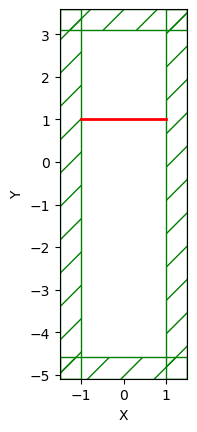

In [7]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


resolution = 180   
res_label = f"{resolution} pix/µm"


porosity = 0.4


thickness_high = 0.05117 
thickness_low = 0.06265   
n_pairs = 5           
n_layers = 10        

# wavelength range: 300 nm to 700 nm
lam_min = 0.35            # µm (300 nm)
lam_max = 0.7            # µm (700 nm)
fmax = 1.0 / lam_min     # = 3.333 (1/µm)
fmin = 1.0 / lam_max     # = 1.429 (1/µm)
fcen = 1/0.5             # center frequency = 2.0 (500 nm)
df = fmax - fmin         # bandwidth


geometry = []
y_bottom = 0.0  

# 1. DBR stack (10 layers)
print(f"\n=== Building structure from bottom to top ===")
print(f"1. DBR: {n_layers} layers")
for i in range(n_layers):
    if i % 2 == 0:  # even indices = GaN
        mat = GaN
        layer_thick = thickness_high
    else:           # odd indices = porous GaN
        mat = porous_gan_linear
        layer_thick = thickness_low
    
    y_center = y_bottom - 0.5 * layer_thick
    geometry.append(mp.Block(size=mp.Vector3(mp.inf, layer_thick, mp.inf),
                             center=mp.Vector3(0, y_center, 0),
                             material=mat))
    y_bottom -= layer_thick

print(f"   DBR top at y = {y_bottom:.4f} µm ({y_bottom*1000:.1f} nm)")

# 2. GaN layer (0.67 µm)
layergan = 0.67
y_center = y_bottom - 0.5 * layergan
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layergan, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=GaN))
y_bottom -= layergan
print(f"2. GaN layer: {layergan*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 3. Graded region (1.7 µm)
grading_height = 1.7
mat_bottom = AlGaN_linear(0.75)
mat_top = AlGaN_linear(0.26)
grading_center_y = y_bottom - 0.5 * grading_height

def graded_y_func(p):
    y_min = grading_center_y - grading_height / 2
    y_max = grading_center_y + grading_height / 2
    
    if y_min <= p.y <= y_max:
        normalized_y = (p.y - y_min) / grading_height
        frac = 0.75 + (0.75 - 0.26) * normalized_y
        
        return AlGaN_linear(frac)
    elif p.y < y_min:
        return AlGaN_linear(0.75)
    else:
        return AlGaN_linear(0.26)

geometry.append(mp.Block(
    center=mp.Vector3(0, grading_center_y, 0),
    size=mp.Vector3(mp.inf, grading_height, mp.inf),
    material=graded_y_func
))
y_bottom -= grading_height
print(f"3. Graded region: {grading_height*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 4. AlGaN layer (250 nm)
layeraln = 0.25
y_center = y_bottom - 0.5 * layeraln
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layeraln, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=AlN))
y_bottom -= layeraln
print(f"4. AlGaN layer: {layeraln*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 5. Si substrate (2 µm)
layersi = 3
y_center = y_bottom - 0.5 * layersi
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layersi, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=mymaterial))
y_bottom -= layersi
print(f"5. Si substrate: {layersi*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

total_structure_height = -y_bottom
print(f"\nTotal structure height: {total_structure_height:.2f} µm")

# Cell dimensions and positioning
sx = 3.0
dpml = 0.5  # PML thickness



src_y = 1.0
refl_y = 0.5



top_space = src_y + dpml + 0.5  
bottom_space = 0.5 

sy = top_space + total_structure_height + bottom_space


geometry_center_y = -(total_structure_height/2) + (sy/2) - top_space

cell = mp.Vector3(sx, sy, 0)
shifted_origin = mp.Vector3(0, geometry_center_y, 0)
pml_layers = [mp.PML(dpml)]


cell_bottom = -sy/2
cell_top = sy/2
pml_bottom_start = cell_bottom
pml_bottom_end = cell_bottom + dpml
structure_bottom = geometry_center_y - total_structure_height/2
structure_top = geometry_center_y + total_structure_height/2
si_bottom = structure_bottom

print(f"\n=== Cell and geometry positioning ===")
print(f"Cell size: {sx} x {sy:.2f} µm")
print(f"Cell range: y ∈ [{cell_bottom:.2f}, {cell_top:.2f}] µm")
print(f"Bottom PML: y ∈ [{pml_bottom_start:.2f}, {pml_bottom_end:.2f}] µm")
print(f"Geometry center: {shifted_origin}")
print(f"Structure top: y = {structure_top:.2f} µm")
print(f"Structure bottom: y = {structure_bottom:.2f} µm")
print(f"Si bottom: y = {si_bottom:.2f} µm")
print(f"Si intersects PML: {si_bottom < pml_bottom_end}")

print(f"\n=== Source and measurement planes ===")
print(f"Source position: y = {src_y:.2f} µm (above structure)")
print(f"Reflection plane: y = {refl_y:.2f} µm (above structure, measures upward flux)")

# Source 
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, src_y, 0),
                     size=mp.Vector3(sx-2*dpml, 0, 0))]

nfreq = 500


refl_fr = mp.FluxRegion(center=mp.Vector3(0, refl_y, 0), 
                        size=mp.Vector3(sx-2*dpml, 0, 0))

# Probe point for field decay - at reflection plane
pt = mp.Vector3(0, refl_y, 0)

# Simulation stopping criteria
stop_time = 100      
decay_threshold = 1e-3  

print(f"\nFrequency range: {fmin:.3f} to {fmax:.3f} (1/µm)")
print(f"Wavelength range: {lam_min*1e3:.0f} to {lam_max*1e3:.0f} nm")
print(f"Gaussian pulse center: {1/fcen*1e3:.0f} nm, width: {df:.3f} (1/µm)")
print(f"Stopping criteria: field decay to {decay_threshold} after source turns off")
print("\n" + "="*50)
print("Starting simulation setup...")
print("="*50)


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry_center=shifted_origin,
                    sources=sources,
                    resolution=resolution)

# Plot the structure
plt.figure(dpi=100)
sim.plot2D()
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00153589 s
Working in 2D dimensions.
Computational cell is 3 x 8.68889 x 0 with resolution 180
time for set_epsilon = 0.744992 s
-----------
on time step 588 (time=1.63333), 0.00680825 s/step
on time step 1280 (time=3.55556), 0.00578101 s/step
on time step 1935 (time=5.375), 0.00611416 s/step
on time step 2626 (time=7.29444), 0.0057957 s/step
on time step 3296 (time=9.15556), 0.00597666 s/step
on time step 3998 (time=11.1056), 0.00570415 s/step
on time step 4683 (time=13.0083), 0.00584417 s/step
on time step 5386 (time=14.9611), 0.0056914 s/step
on time step 6108 (time=16.9667), 0.00554409 s/step
on time step 6805 (time=18.9028), 0.00574682 s/step
on time step 7508 (time=20.8556), 0.00569482 s/step
on time step 8161 (time=22.6694), 0.00612683 s/step
on time step 8755 (time=24.3194), 0.00673858 s/step
on time step 9390 (time=26.0833), 0.00630215 s/step
on time step 10060 (time=27.9444), 0.00597241 s/step
on time ste

field decay(t = 200.00555555555556): 1.3942120262539409e-16 / 0.3065246125471111 = 4.548450496906372e-16
run 0 finished at t = 200.00555555555556 (72002 timesteps)
Normalization run complete.

Starting full structure simulation...
     block, center = (0,-0.025585,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.6,3.6,5.35)
     block, center = (0,-0.082495,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,3.61)
     block, center = (0,-0.139405,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.6,3.6,5.35)
     block, center = (0,-0.196315,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,3.61)
     block, center = (0,-0.253225,0)
          si

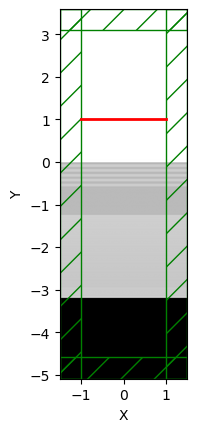

-----------
Initializing structure...
time for choose_chunkdivision = 0.00080204 s
Working in 2D dimensions.
Computational cell is 3 x 8.68889 x 0 with resolution 180
     block, center = (0,-0.025585,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.6,3.6,5.35)
     block, center = (0,-0.082495,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,3.61)
     block, center = (0,-0.139405,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.6,3.6,5.35)
     block, center = (0,-0.196315,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,3.61)
     block, center = (0,-0.253225,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

RuntimeError: meep: simulation fields are NaN or Inf

In [8]:
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources=mp.stop_when_fields_decayed(stop_time, mp.Ez, pt, decay_threshold))

straight_refl_data = sim.get_flux_data(refl)
# Get incident flux for normalization (from reflection plane in free space run)
incident_flux = np.array(mp.get_fluxes(refl))

print("Normalization run complete.")
print("\n" + "="*50)
print("Starting full structure simulation...")
print("="*50)

sim.reset_meep()

# run with full geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    geometry_center=shifted_origin,
                    sources=sources,
                    resolution=resolution)

%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.show()

refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.load_minus_flux_data(refl, straight_refl_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(stop_time, mp.Ez, pt, decay_threshold))

dbr_refl_flux = np.array(mp.get_fluxes(refl))
freqs = np.array(mp.get_flux_freqs(refl))

print("Full structure simulation complete.")

# Compute reflectance
wls = 1.0 / freqs  # wavelengths in µm

R = -dbr_refl_flux / incident_flux  

# Plotting
if mp.am_master():
    plt.figure(figsize=(10, 6))
    plt.plot(wls*1e3, R, 'b-', label='Reflectance', linewidth=2)
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Reflectance', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.xlim(300, 700)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('structure_reflectance.png', dpi=150)
    plt.show()
    
    # Diagnostics
    print(f"\n{'='*50}")
    print("RESULTS")
    print(f"{'='*50}")
    print(f"\nReflectance at key wavelengths:")
    for target_wl in [400, 450, 500, 550, 600]:
        idx = np.argmin(np.abs(wls*1e3 - target_wl))
        actual_wl = wls[idx]*1e3
        print(f"  λ = {actual_wl:.1f} nm: R = {R[idx]:.4f}")
    
    max_R_idx = np.argmax(R)
    min_R_idx = np.argmin(R)
    print(f"\nPeak reflectance: R = {R[max_R_idx]:.4f} at λ = {wls[max_R_idx]*1e3:.1f} nm")
    print(f"Min reflectance:  R = {R[min_R_idx]:.4f} at λ = {wls[min_R_idx]*1e3:.1f} nm")
    
    # Check for unphysical results
    if np.any(R > 1.0) or np.any(R < -0.01):
        print("\n⚠️  WARNING: Unphysical reflectance values detected!")
        print(f"   Max R = {np.max(R):.4f}, Min R = {np.min(R):.4f}")
    else:
        print("\n✓ All reflectance values are physical (0 ≤ R ≤ 1)")